 # [Module 2.5] CatBoost 훈련 및 추론

이 노트북은 아래와 같은 작업을 합니다.
- 훈련, 검증 데이터 로딩
- Category 인덱스 추출
- CatBoost 훈련
- 테스트 데이터 로딩 및 추론
- 모델 평가
- 피쳐 Importance 생성

In [1]:
import pandas as pd

In [2]:
%store -r te_pre_train_file
# %store -r pre_val_file
%store -r te_pre_test_file

In [3]:
te_pre_train_file

'preproc_data/fe/te_xgboost/train.csv'

## 훈련, 검증 데이터 세트 로딩

In [4]:
train_df = pd.read_csv(te_pre_train_file, header=None, skiprows=1)
# val_df = pd.read_csv(pre_val_file, header=None, skiprows=1)
print("train_df: ", train_df.shape)
# print("val_df: ", val_df.shape)

train_df:  (53740, 19)


In [5]:
from IPython.display import display
display(train_df.head())
# display(val_df.head())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,29.99,10.96,9000.0,2640.0,1,4,10,2.175063,2.625703,2.068789,1.797406,1.730057,2.183227,1.619101,2.163043,2.262911,1.775514,2.134582
1,2,23.90,26.82,1500.0,14625.0,1,4,10,2.180955,2.243557,2.073626,2.219753,2.209925,2.172901,3.152118,2.188721,2.222551,3.150102,2.164053
2,4,249.90,17.59,610.0,4928.0,1,4,10,2.182587,2.028565,2.151057,2.141850,2.113293,2.136123,2.626927,2.155294,2.369897,2.487868,2.171569
3,4,89.90,17.51,1850.0,10764.0,1,4,10,2.185584,2.194091,2.113418,1.960980,2.178909,2.196817,2.642480,2.155102,2.648678,2.473836,2.183380
4,2,93.90,17.61,1200.0,12500.0,1,4,10,2.170692,2.238277,2.477206,2.152751,2.179731,2.169582,2.831505,2.163499,2.472426,2.549165,2.147510


In [6]:
X_train, y_train = train_df.iloc[:,1:], train_df.iloc[:,0]
# X_val, y_val = val_df.iloc[:,1:], val_df.iloc[:,0]

## 레이블 인코딩된 category 인덱스 추출
- CatBoost 알고리즘에 category 인덱스를 알려 주기 위해서 임

In [7]:
cat_features_index = X_train.columns[X_train.dtypes == 'int64'].tolist()
cat_features_index = [num -1 for num in cat_features_index]
cat_features_index

[4, 5, 6]

## CatBoost 훈련


In [8]:
%%time 

import catboost as cb

clf = cb.CatBoostClassifier(eval_metric="Accuracy",max_depth=5,
                           iterations = 500)
# clf.fit(X_train, y_train, verbose=False, cat_features = cat_features_index)
clf.fit(X_train, y_train, verbose=False)


CPU times: user 1min 3s, sys: 5.7 s, total: 1min 9s
Wall time: 33.1 s


In [9]:
# clf.score(X_val, y_val)

## Test 데이터로 평가

In [10]:
test_df = pd.read_csv(te_pre_test_file, header=None,skiprows=1)
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,3,105.00,23.89,1000.0,7632.0,1,19,6,2.391845,2.234761,2.124288,2.107862,2.672263,2.209053,2.180187,2.186401,2.523131,2.703099,2.213403
1,0,99.97,15.80,650.0,9600.0,1,19,6,2.170855,2.035820,2.354760,1.977483,2.142477,2.198389,2.317828,2.130447,1.643000,1.788799,2.190784
2,3,76.99,23.34,1850.0,3000.0,1,19,6,2.168951,1.923805,2.112038,1.928440,2.186759,2.190161,2.617422,2.166904,2.159153,2.521050,2.172353
3,2,64.90,15.55,200.0,4752.0,1,19,6,2.144415,2.179984,2.078391,1.911920,2.192858,2.534707,2.640869,2.197390,2.466845,2.501713,2.181140
4,4,75.00,27.51,2550.0,31500.0,1,19,6,2.176373,2.230431,2.132108,1.916739,2.201885,2.170277,2.812890,2.188364,2.797829,2.789558,2.146462


In [11]:
X_test, y_test = test_df.iloc[:,1:], test_df.iloc[:,0]

In [12]:
prediction = clf.predict(X_test)

## 모델 평가

In [13]:
from sklearn.metrics import accuracy_score, f1_score
accuracy = accuracy_score(y_test, prediction)
f1_score = f1_score(y_test, prediction, average='macro')
print("accuracy: %.2f%%" % accuracy)
print("f1_score: %.2f%%" % f1_score)

accuracy: 0.45%
f1_score: 0.43%


[[ 888  485  309   21    2]
 [ 304 1320 1723  717   98]
 [ 175  407 2473 1024  456]
 [  62  160  614 1099  233]
 [  17   48  285  267  249]]


<Figure size 432x288 with 0 Axes>

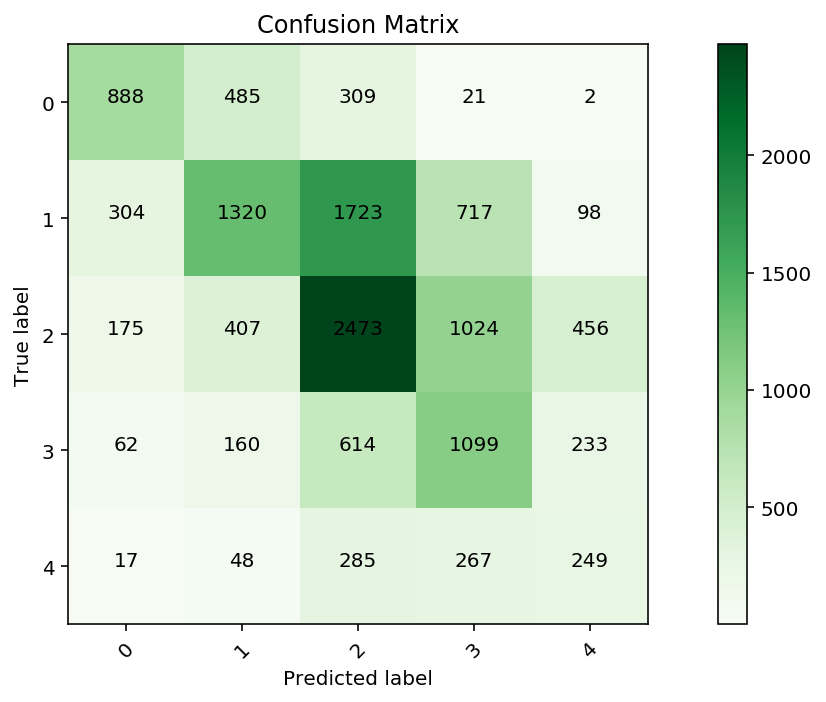

In [15]:
from p_utils import plot_conf_mat


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

cm = confusion_matrix(y_true= y_test, y_pred= prediction)

plt.figure()
fig, ax = plt.subplots(figsize=(10,5))
plot_conf_mat(cm, 
              classes=['0','1', '2', '3', '4'], 
              title='Confusion Matrix')
plt.show()

## Feature Importance

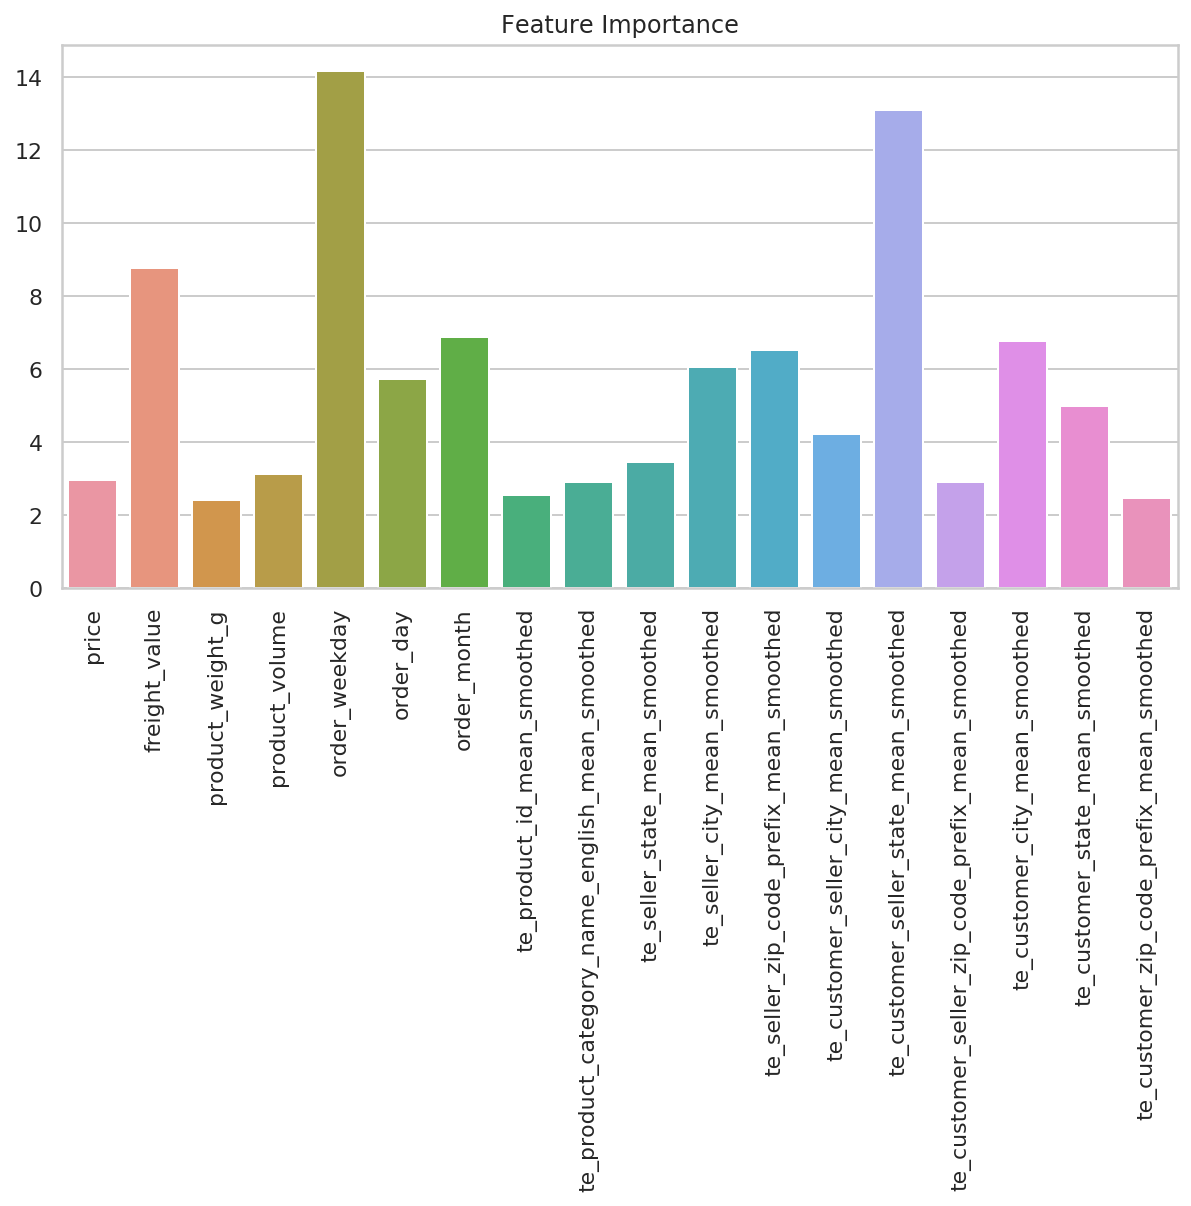

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")


test_col_df = pd.read_csv(te_pre_test_file)
features = test_col_df.columns[1:]
fea_importance = clf.feature_importances_

f, ax = plt.subplots(figsize=(10,5))
plot = sns.barplot(x=features, y= fea_importance)
ax.set_title('Feature Importance')
plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
plt.show()